## About

This page showcases the work of [Tuo Wang](https://tuowang.rbind.io/) that introduces packages to make [`ggplot2`](https://ggplot2.tidyverse.org/) plots more beautiful. You can find the original [R](https://www.r-graph-gallery.com/) code on Tuo's blog [here](https://tuowang.rbind.io). 

Thanks to him for accepting sharing his work here! Thanks also to [Tomás Capretto](https://tomicapretto.github.io/) who translated this work from R to Python! 🙏🙏

As a teaser, here is the plot we’re gonna try building:

![preview final chart](https://github.com/holtzy/The-Python-Graph-Gallery/blob/master/static/graph/web-ggbetweenstats-with-matplotlib-square.png?raw=true)

## Load libraries

Today's visualization uses the numeric libraries NumPy and SciPy to manipulate the data for the plot. In addition, `load_penguins()` function is imported from the `palmerpenguins` library to have access to the popular palmerpenguins dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

from palmerpenguins import load_penguins

## Load and prepare the data

The dataset used today was collected and made available by [Dr. Kristen Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php) and the [Palmer Station, Antarctica LTER](https://pal.lternet.edu/), a member of the [Long Term Ecological Research Network](https://lternet.edu/). This dataset was popularized by [Allison Horst](https://www.allisonhorst.com/) in her R package [`palmerpenguins`](https://allisonhorst.github.io/palmerpenguins/) with the goal to offer an alternative to the iris dataset for data exploration and visualization.

In [2]:
penguins = load_penguins()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


The first step is to drop observations with missing values.

In [3]:
penguins = penguins.dropna()

The chart is going to compare the distribution of the bill length (`bill_length_mm`) across the three species of penguins available in the data (Adelie, Chinstrap, and Gentoo).

`ax.violinplot()` is used to obtain the violins. This method requires a list or an array where each element contains the data for each species. Boxplots are made with `ax.boxplot()`, which requires the data in a similar format. Finally, a jittered version of the bill lengths for each species is added. The jitter is generated with a custom probability distribution to have more control on its appearence and improve the final result.

In [4]:
# Get the species, sorted alphabetically
species = sorted(penguins["species"].unique())

# y_data is a list of length 3 containing the bill_length_mm values for each specie 
y_data = [penguins[penguins["species"] == specie]["bill_length_mm"].values for specie in species]

# Create jittered version of "x" (which is only 0, 1, and 2)
# More about this in the bonus track!
jitter = 0.04
x_data = [np.array([i] * len(d)) for i, d in enumerate(y_data)]
x_jittered = [x + st.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]

## Basic violinplot

The first step is to define colors and utilities that are going to be used throughout the construction of the chart.

In [5]:
# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = ["#1B9E77", "#D95F02", "#7570B3"]

# Horizontal positions for the violins. 
# They are arbitrary numbers. They could have been [-1, 0, 1] for example.
POSITIONS = [0, 1, 2]

# Horizontal lines
HLINES = [40, 50, 60]

Then, let's initialize the chart layout, add a background color and the basic data layers. For each species, this chunk of code first adds a violinplot, then a boxplot, and finally the jittered data points.

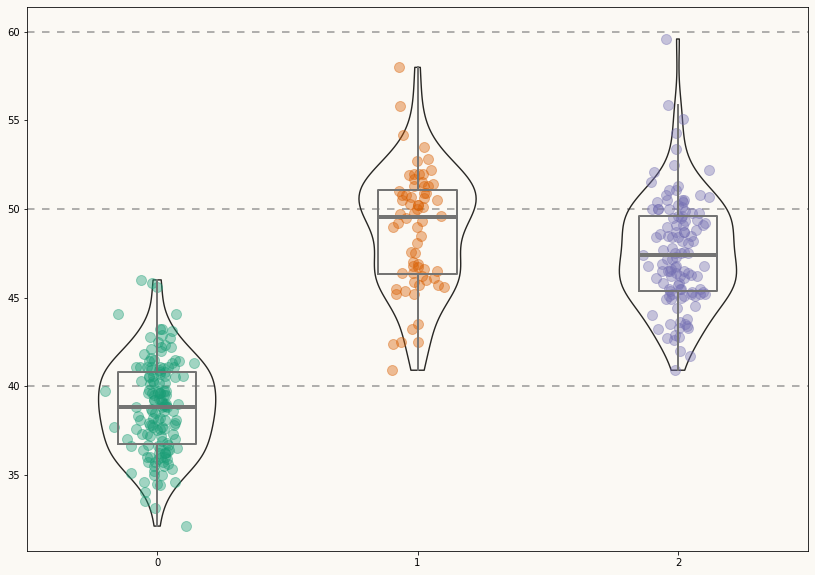

In [6]:
fig, ax = plt.subplots(figsize= (14, 10))

# Some layout stuff ----------------------------------------------
# Background color
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)

# Horizontal lines that are used as scale reference
for h in HLINES:
    ax.axhline(h, color=GREY50, ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
# More on this in the bonus track ;)

# The output is stored in 'violins', used to customize their appearence
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins (remove fill, customize line, etc.)
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)
    

# Add boxplots ---------------------------------------------------
# Note that properties about the median and the box are passed
# as dictionaries.

medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers = False, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    medianprops = medianprops,
    whiskerprops = boxprops,
    boxprops = boxprops
)

# Add jittered dots ----------------------------------------------
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s = 100, color=color, alpha=0.4)

Not a bad start! Now it's time to add some statistical information in a good-looking fashion.

## Add custom annotations

This plot looks very pretty. However, it still lacks **statistical information** that allows readers to make precise comparisons between the penguin species.

It would be very nice to have labels for the mean values of each distribution and extra annotations to assist the multiple comparisons with statistical information. Let's go for it!

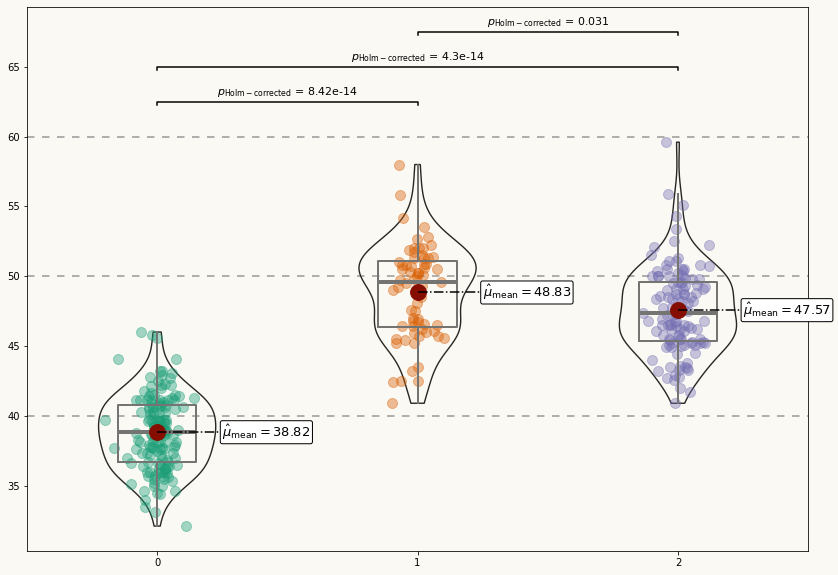

In [7]:
# Add mean value labels ------------------------------------------
means = [y.mean() for y in y_data]
for i, mean in enumerate(means):
    # Add dot representing the mean
    ax.scatter(i, mean, s=250, color=RED_DARK, zorder=3)
    
    # Add line conecting mean value and its label
    ax.plot([i, i + 0.25], [mean, mean], ls="dashdot", color="black", zorder=3)
    
    # Add mean value label.
    ax.text(
        i + 0.25,
        mean,
        r"$\hat{\mu}_{\rm{mean}} = $" + str(round(mean, 2)),
        fontsize=13,
        va="center",
        bbox = dict(
            facecolor="white",
            edgecolor="black",
            boxstyle="round",
            pad=0.15
        ),
        zorder=10 # to make sure the line is on top
    )

# Add multiple comparisons p-value for mean difference -----------
# Plot lines indicating what means are compared
# 'tick_len' gives the length of the tick on the end of each line

tick_len = 0.25
ax.plot([0, 0, 1, 1], [62.5 - tick_len, 62.5, 62.5, 62.5 - tick_len], c="black")
ax.plot([0, 0, 2, 2], [65 - tick_len, 65, 65, 65 - tick_len], c="black")
ax.plot([1, 1, 2, 2], [67.5 - tick_len, 67.5, 67.5, 67.5 - tick_len], c="black")

# Add labels for the p-values
label1 = r"$p_{\rm{Holm-corrected}}$ = 8.42e-14"
label2 = r"$p_{\rm{Holm-corrected}}$ = 4.3e-14"
label3 = r"$p_{\rm{Holm-corrected}}$ = 0.031"

pad = 0.2
ax.text(0.5, 62.5 + pad, label1, fontsize=11, va="bottom", ha="center")
ax.text(1, 65 + pad, label2, fontsize=11, va="bottom", ha="center")
ax.text(1.5, 67.5 + pad, label3, fontsize=11, va="bottom", ha="center")   

fig

## Final chart

Although the plot above looks quite nice, it still misses some important information. What is the meaning of the numbers in the horizontal axis? The distribution of which variable is being compared? This chart deserves better axes labels, an appropriate title, and more insightful customized annotations. Let's do it!

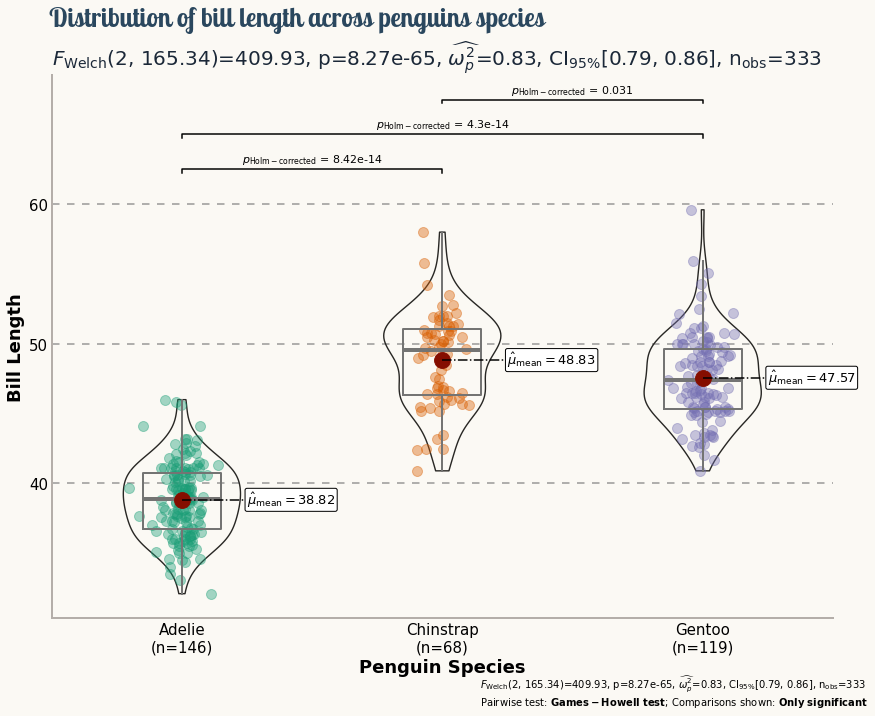

In [8]:
# Customize layout -----------------------------------------------
# Hide spines
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Customize spines color
ax.spines["left"].set_color(GREY_LIGHT)
ax.spines["left"].set_linewidth(2)
ax.spines["bottom"].set_color(GREY_LIGHT)
ax.spines["bottom"].set_linewidth(2)

# Customize labels and ticks
ax.tick_params(length=0)
ax.set_yticks(HLINES)
ax.set_yticklabels(HLINES, size=15)
ax.set_ylabel("Bill Length", size=18, weight="bold")

# xlabels accounts for the sample size for each species
xlabels = [f"{specie}\n(n={y_data[i].size})" for i, specie in enumerate(species)]
ax.set_xticks(POSITIONS)
ax.set_xticklabels(xlabels, size=15, ha="center", ma="center")
ax.set_xlabel("Penguin Species", size=18, weight="bold")

# Figure is used for the title and the axis is used for the subtitle
# Title
stats = [
    r"$\log_{\rm{e}}(\rm{BF}_{01})=-195.59$",
    r"$\widehat{R^2}_{\rm{Bayesian}}^{\rm{posterior}}=0.70$",
    r"$\rm{CI}_{95\%}^{\rm{HDI}}[0.67, 0.73]$",
    r"$r^{\rm{Cauchy}}_{\rm{JZS}} = 0.71$",
]

fig.suptitle(
    "Distribution of bill length across penguins species",
    x = 0.122,
    y = 0.975,
    ha="left",
    fontsize=26,
    fontname="Lobster Two",
    color=BLUE,
    weight="bold",    
)

# Subtitle   
stats = [
    r"$F_{\rm{Welch}}$(2, 165.34)=409.93",
    r"p=8.27e-65",
    r"$\widehat{\omega_p^2}$=0.83",
    r"CI$_{95\%}$[0.79, 0.86]",
    r"n$_{\rm{obs}}$=333"
]

ax.set_title(
    ", ".join(stats),
    loc="left",
    ha="left",
    fontsize=20,
    color=BLUE_DARK
)

# Notes on bottom-right
fig.text(
    0.55,
    0.03,
    ", ".join(stats),
    fontsize=10
)

fig.text(
    0.55,
    0.005,
    r"Pairwise test: $\bf{Games-Howell}$ $\bf{test}$; Comparisons shown: $\bf{Only}$ $\bf{significant}$",
    fontsize=10
)

fig

## Bonus: How does the jitter work?

Without jitter, the representation of the bill lengths for a given species would be placed on a vertical line. Jittering is added to reduce overlap and make it easier to perceive the shape of the distribution.

Jitter is usually produced by adding a random number obtained from a uniform distribution centered at 0. Negative values shift the dot to the left, positive ones shift the dot to the right. Thus, the dots aren't placed on a vertical line anymore but uniformly distributed within a band of a certain width.

In this example, a customized jitter is used. A t-student distribution is used instead of a uniform one. This distribution is like a normal distribution but has heavier tails. What does it mean? Well, instead of having dots scattered within a uniform band, the pattern looks more random, with some dots presenting larger deviations from the middle (thanks to the heavier tails).

## Bonus: What is the Silverman bandwidth?

If you compare the plot obtained above with the [original one](https://tuowang.rbind.io/post/2021-03-25-ggplot2-extensions/7.png), you'll notice the violins don't look exactly the same. That's because of the bandwidth. The bandwidth determines the smoothness of the density estimation used in the violinplot. With `bw_method = "silverman"` matplotlib is instructed to compute the bandwidth via Silverman's rule, because that is what is used in ggplot2.

So why the results don't look the same? Is there a random component there?

Nope! It just turns out that matplotlib implements a modified version of the Silverman's rule for the bandwidth, which means that using Silverman's rule in ggplot2 is not the same than using Silverman's rule in matplotlib.